### Importing libraries

In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.graphics.tsaplots as sgt
from scipy.stats.distributions import chi2
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.stattools as sts

### Importing data and preprocessing

In [2]:
#reading in the data and performing basic preprocessing
data = pd.read_csv('Index2018.csv')
df = data.copy #copying the dataframe
df.date = pd.to_datetime(df.date, dayfirst = True) #parsing dates
df.set_index('date', inplace = True) #setting date column as index
df.asfreq('b') #setting a constant frequency as business days
df.fillna('ffill') #filling missing or nan values

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.900000,2224.95,3445.980000,18124.01
1994-01-10,475.270000,2225.00,3440.580000,18443.44
1994-01-11,474.130000,2228.10,3413.770000,18485.25
1994-01-12,474.170000,2182.06,3372.020000,18793.88
1994-01-13,472.470000,2142.37,3360.010000,18577.26
...,...,...,...,...
2018-01-23,2839.130362,13559.60,7731.827774,24124.15
2018-01-24,2837.544008,13414.74,7643.428966,23940.78
2018-01-25,2839.253031,13298.36,7615.839954,23669.49


In [3]:
# keeping only ftse column and removing rest 
df['market_value'] = df.ftse
del df['spx']
del df['dax']
del df['ftse']
del df['nikkei']

#splitting the data into training and testing data
size = int(len(df)*0.8)
df_train = df.iloc[:size]
df_test = df.iloc[size:]

In [4]:
def LLR_test(model_1, model_2, DF = 1):
    L1 = model_1.fit().llf
    L2 = model_2.fit().llf
    LR = 2*(L2-L1)
    p = chi2.sf(LR, DF).round(3)
    return p

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
#calculating returns
df_train['returns'] = (df_train.market_value.pct_change(1)*100)
df_train = df_train[1:]

## ARMA models

In [12]:
#ARMA(1,1) model
model_ret_arma = ARIMA(df_train.returns, order=(1,0,1))
results_ret_arma = model_ret_arma.fit()
results_ret_arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5013
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -7907.506
Date:                Sat, 28 Jan 2023   AIC                          15823.012
Time:                        15:22:50   BIC                          15849.091
Sample:                             0   HQIC                         15832.151
                               - 5013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0194      0.015      1.323      0.186      -0.009       0.048
ar.L1          0.7663      0.045     17.153      0.000       0.679       0.854
ma.L1         -0.8155      0.040    -20.384      0.000      -0.894      -0.737
sigma2         1.3729      0.014     98.035      0.000       1.345       1.400
===================================================================================
Ljung-Box (L1) (Q):                   2.03   Jarque-Bera (JB):              7472.40
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               2.03   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
#comparing the arma(1,1) model with ar(1) and ma(1) model
model_ar_1 = ARIMA(df_train.returns, order = (1,0,0))
model_ma_1 = ARIMA(df_train.returns, order = (0,0,1))

print('ARMA vs AR: ',LLR_test(model_ar_1, model_ret_arma))
print('ARMA vs MA: ', LLR_test(model_ma_1, model_ret_arma))

ARMA vs AR:  0.0
ARMA vs MA:  0.0


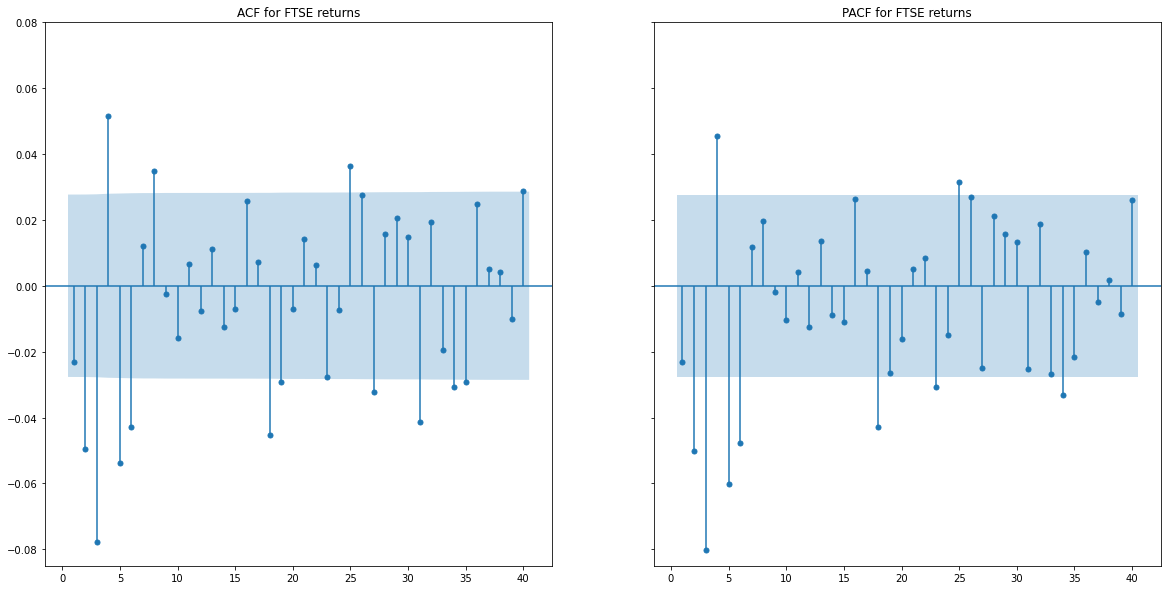

In [22]:
#plotting acf and pacf for returns
plt.rcParams['figure.figsize'] = (20,10)
fig,ax = plt.subplots(nrows = 1, ncols = 2,sharex = True, sharey = True)
p1 = sgt.plot_acf(df_train.returns, lags = 40, zero = False, ax = ax[0], title = 'ACF for FTSE returns')
p2 = sgt.plot_pacf(df_train.returns, lags = 40, zero = False, ax = ax[1], title = 'PACF for FTSE returns')
plt.ylim(-.085,.08)
plt.show()

In [23]:
#fitting higher lags model
model_ret_ar_6_ma_8 = ARIMA(df_train.returns, order = (6,0,8))
results_ret_ar_6_ma_8 = model_ret_ar_6_ma_8.fit()
results_ret_ar_6_ma_8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5013
Model:                 ARIMA(6, 0, 8)   Log Likelihood               -7873.666
Date:                Sat, 28 Jan 2023   AIC                          15779.331
Time:                        15:39:45   BIC                          15883.648
Sample:                             0   HQIC                         15815.888
                               - 5013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0194      0.015      1.336      0.181      -0.009       0.048
ar.L1         -0.4727      0.552     -0.857      0.391      -1.554       0.608
ar.L2         -0.3581      0.401     -0.893      0.372      -1.144       0.428
ar.L3          0.1879      0.244      0.770      0.441      -0.290       0.666
ar.L4          0.4314      0.215      2.009      0.045       0.010       0.852
ar.L5          0.7055      0.376      1.877      0.061      -0.031       1.442
ar.L6          0.1719      0.163      1.053      0.292      -0.148       0.492
ma.L1          0.4485      0.550      0.815      0.415      -0.630       1.527
ma.L2          0.2967      0.404      0.734      0.463      -0.496       1.089
ma.L3         -0.3054      0.243     -1.259      0.208      -0.781       0.170
ma.L4         -0.4363      0.210     -2.075      0.038      -0.848      -0.024
ma.L5         -0.7340      0.351     -2.091      0.037      -1.422      -0.046
ma.L6         -0.1448      0.152     -0.950      0.342      -0.443       0.154
ma.L7          0.0447      0.041      1.084      0.278      -0.036       0.125
ma.L8          0.0763      0.040      1.890      0.059      -0.003       0.155
sigma2         1.3545      0.015     88.654      0.000       1.325       1.384
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6434.12
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.99   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
#10 out of the 14 coeff other than the constatnt terms are not significant. Our model is way too complex, we lower it down
#Let's try ARMA(3,3)
model_ret_ar_3_ma_3 = ARIMA(df_train.returns, order = (3,0,3))
results_ret_ar_3_ma_3 = model_ret_ar_3_ma_3.fit()
results_ret_ar_3_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5013
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -7884.805
Date:                Sat, 28 Jan 2023   AIC                          15785.610
Time:                        15:46:39   BIC                          15837.768
Sample:                             0   HQIC                         15803.888
                               - 5013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0194      0.015      1.317      0.188      -0.009       0.048
ar.L1         -0.2000      0.067     -2.980      0.003      -0.332      -0.068
ar.L2         -0.2771      0.054     -5.124      0.000      -0.383      -0.171
ar.L3          0.4526      0.062      7.342      0.000       0.332       0.573
ma.L1          0.1807      0.062      2.898      0.004       0.058       0.303
ma.L2          0.2114      0.052      4.075      0.000       0.110       0.313
ma.L3         -0.5505      0.057     -9.739      0.000      -0.661      -0.440
sigma2         1.3605      0.015     92.254      0.000       1.332       1.389
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):              6835.64
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
LLR_test(model_ret_arma, model_ret_ar_3_ma_3, DF = 4)

0.0

In [27]:
#lets try more simpler models and see if they are better
model_ret_ar_3_ma_2 = ARIMA(df_train.returns, order = (3,0,2))
results_ret_ar_3_ma_2 = model_ret_ar_3_ma_2.fit()
print(results_ret_ar_3_ma_2.summary())
print(LLR_test(model_ret_ar_3_ma_2, model_ret_ar_3_ma_3, DF = 1))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5013
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -7887.424
Date:                Sat, 28 Jan 2023   AIC                          15788.849
Time:                        15:49:21   BIC                          15834.487
Sample:                             0   HQIC                         15804.842
                               - 5013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0194      0.016      1.246      0.213      -0.011       0.050
ar.L1         -0.6806      0.055    -12.357      0.000      -0.789      -0.573
ar.L2         -0.5192      0.063     -8.239      0.0

In [28]:
model_ret_ar_2_ma_3 = ARIMA(df_train.returns, order = (2,0,3))
results_ret_ar_2_ma_3 = model_ret_ar_2_ma_3.fit()
print(results_ret_ar_2_ma_3.summary())
print(LLR_test(model_ret_ar_2_ma_3, model_ret_ar_3_ma_3, DF = 1))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5013
Model:                 ARIMA(2, 0, 3)   Log Likelihood               -7887.238
Date:                Sat, 28 Jan 2023   AIC                          15788.476
Time:                        15:50:23   BIC                          15834.115
Sample:                             0   HQIC                         15804.470
                               - 5013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0194      0.015      1.257      0.209      -0.011       0.050
ar.L1         -0.5645      0.057     -9.888      0.000      -0.676      -0.453
ar.L2         -0.4316      0.065     -6.615      0.0

In [30]:
model_ret_ar_3_ma_1 = ARIMA(df_train.returns, order = (3,0,1))
results_ret_ar_3_ma_1 = model_ret_ar_3_ma_1.fit()
print(results_ret_ar_3_ma_1.summary())
print(LLR_test(model_ret_ar_3_ma_1, model_ret_ar_3_ma_2, DF = 1))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5013
Model:                 ARIMA(3, 0, 1)   Log Likelihood               -7890.942
Date:                Sat, 28 Jan 2023   AIC                          15793.885
Time:                        15:52:25   BIC                          15833.003
Sample:                             0   HQIC                         15807.593
                               - 5013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0194      0.015      1.282      0.200      -0.010       0.049
ar.L1         -0.5043      0.064     -7.939      0.000      -0.629      -0.380
ar.L2         -0.0637      0.009     -7.023      0.0

we see that ARMA(3,2) is better than ARMA(3,1)

In [31]:
model_ret_ar_2_ma_2 = ARIMA(df_train.returns, order = (2,0,2))
results_ret_ar_2_ma_2 = model_ret_ar_2_ma_2.fit()
print(results_ret_ar_2_ma_2.summary())
print(LLR_test(model_ret_ar_2_ma_2, model_ret_ar_3_ma_2, DF = 1))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5013
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -7903.210
Date:                Sat, 28 Jan 2023   AIC                          15818.420
Time:                        15:53:52   BIC                          15857.538
Sample:                             0   HQIC                         15832.128
                               - 5013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0194      0.015      1.320      0.187      -0.009       0.048
ar.L1         -0.2132      0.044     -4.833      0.000      -0.300      -0.127
ar.L2          0.7715      0.044     17.521      0.0

In [32]:
#checking ARMA(1,3) model
model_ret_ar_1_ma_3 = ARIMA(df_train.returns, order = (1,0,3))
results_ret_ar_1_ma_3 = model_ret_ar_1_ma_3.fit()
print(results_ret_ar_1_ma_3.summary())
print(LLR_test(model_ret_ar_1_ma_3, model_ret_ar_3_ma_2, DF = 1))

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5013
Model:                 ARIMA(1, 0, 3)   Log Likelihood               -7888.644
Date:                Sat, 28 Jan 2023   AIC                          15789.288
Time:                        15:56:01   BIC                          15828.407
Sample:                             0   HQIC                         15802.997
                               - 5013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0194      0.015      1.299      0.194      -0.010       0.049
ar.L1         -0.4653      0.061     -7.683      0.000      -0.584      -0.347
ma.L1          0.4426      0.061      7.247      0.0

the LLR_test above is void since ARMA(1,3) is not nested in ARMA(3,2) model. Therefore, we must manually compare the LLR of both

In [33]:
print('\nARMA(3,2): \tLLR = ', results_ret_ar_3_ma_2.llf, '\tAIC = ',results_ret_ar_3_ma_2.aic)
print('\nARMA(1,3): \tLLR = ', results_ret_ar_1_ma_3.llf, '\tAIC = ',results_ret_ar_1_ma_3.aic)


ARMA(3,2): 	LLR =  -7887.424452393762 	AIC =  15788.848904787525

ARMA(1,3): 	LLR =  -7888.644191113959 	AIC =  15789.288382227918


As we see, ARMA(3,2) outperforms ARMA(1,3)

### analysing residuals

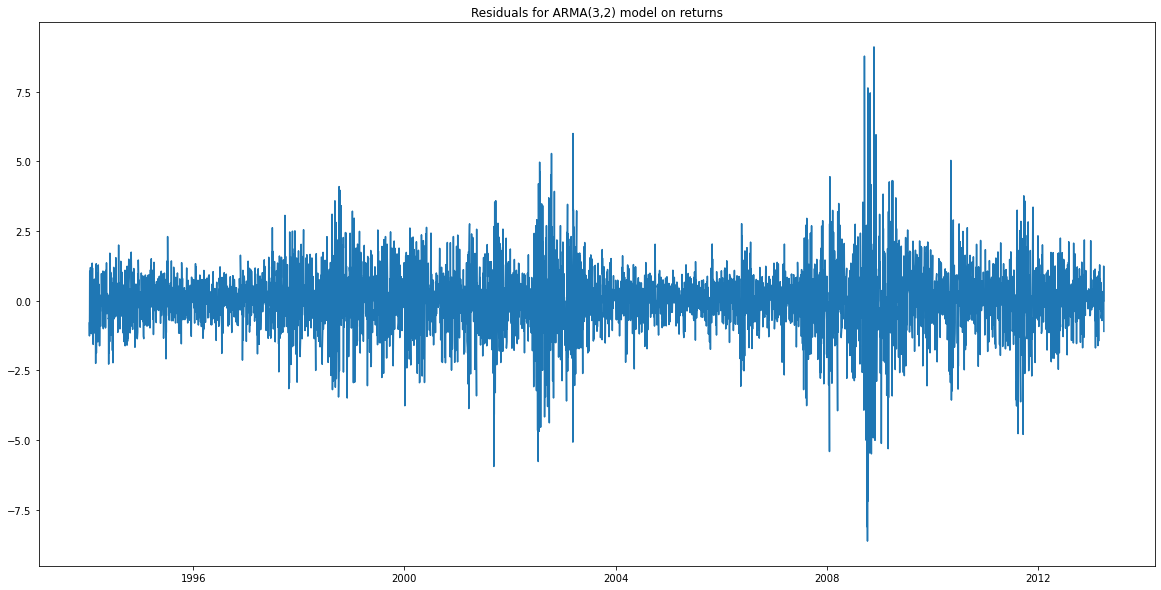

In [37]:
df_train['residuals_returns'] = results_ret_ar_3_ma_2.resid

#plotting the residuals
plt.plot(df_train['residuals_returns'])
plt.title('Residuals for ARMA(3,2) model on returns',size = 12)
plt.show()

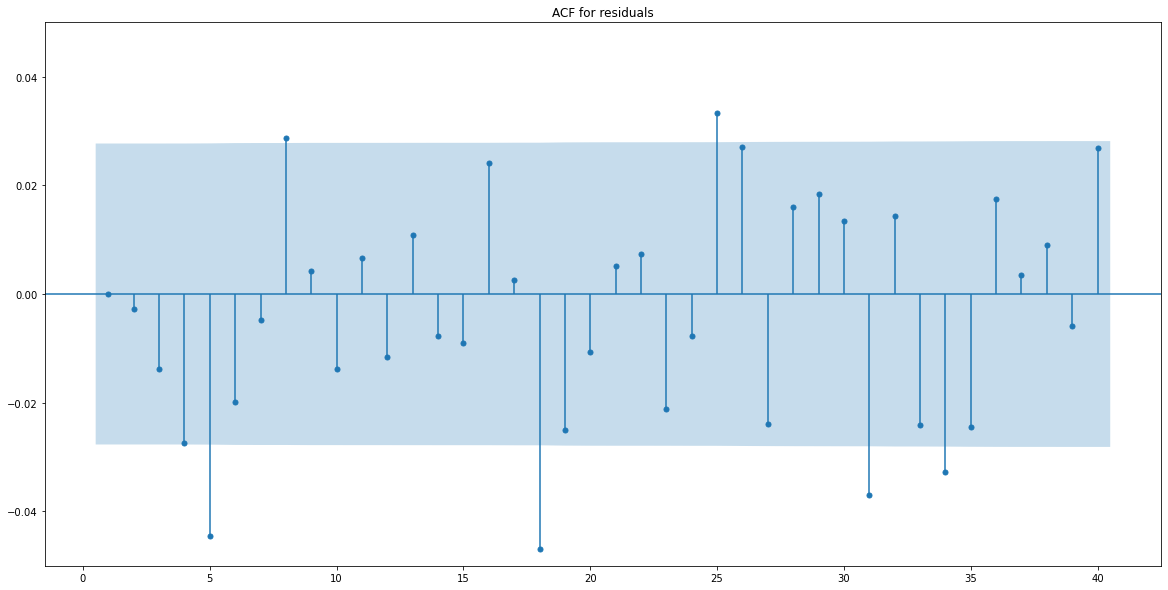

In [38]:
#plotting acf 
sgt.plot_acf(df_train.residuals_returns, lags = 40, zero = False)
plt.title("ACF for residuals", size = 12)
plt.ylim(-.05,.05)
plt.show()

We see a few acf being significant, in particular the one for the 5th lag.

This indicates that we must incorporate the 5th lag component for either of AR or MA components if not both

## Re-selecting the best model

In [39]:
#we start with ARMA(5,5) and move towards simpler models
model_ret_ar_5_ma_5 = ARIMA(df_train.returns, order = (5,0,5))
results_ret_ar_5_ma_5 = model_ret_ar_5_ma_5.fit()
print(results_ret_ar_5_ma_5.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 5013
Model:                 ARIMA(5, 0, 5)   Log Likelihood               -7873.842
Date:                Sat, 28 Jan 2023   AIC                          15771.683
Time:                        16:23:57   BIC                          15849.921
Sample:                             0   HQIC                         15799.101
                               - 5013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0181      0.015      1.232      0.218      -0.011       0.047
ar.L1         -0.0501      0.108     -0.463      0.643      -0.262       0.162
ar.L2         -0.5704      0.076     -7.464      0.0

In [54]:
#nearly half the components are non-significant suggesting us that there is a simpler model which will perform better
#we check the nested models of ARMA(5,5)

#model_ret_ar_4_ma_5 = ARIMA(df_train.returns, order = (4,0,5))
#results_ret_ar_4_ma_5 = model_ret_ar_4_ma_5.fit()
#print(results_ret_ar_4_ma_5.summary())
#print(LLR_test(model_ret_ar_4_ma_5, model_ret_ar_5_ma_5, DF = 1))
#ARMA(5,5) is not better than ARMA(4,5)

#model_ret_ar_3_ma_5 = ARIMA(df_train.returns, order = (3,0,5))
#results_ret_ar_3_ma_5 = model_ret_ar_3_ma_5.fit()
#print(results_ret_ar_3_ma_5.summary())
#print(LLR_test(model_ret_ar_3_ma_5, model_ret_ar_4_ma_5, DF = 1))
#ARMA(4,5) is not better than ARMA(3,5)

#model_ret_ar_2_ma_5 = ARIMA(df_train.returns, order = (2,0,5))
#results_ret_ar_2_ma_5 = model_ret_ar_2_ma_5.fit()
#print(results_ret_ar_2_ma_5.summary())
#print(LLR_test(model_ret_ar_2_ma_5, model_ret_ar_3_ma_5, DF = 1))
#ARMA(3,5) is not better than ARMA(2,5)

#model_ret_ar_1_ma_5 = ARIMA(df_train.returns, order = (1,0,5))
#results_ret_ar_1_ma_5 = model_ret_ar_1_ma_5.fit()
#print(results_ret_ar_1_ma_5.summary())
#print(LLR_test(model_ret_ar_1_ma_5, model_ret_ar_2_ma_5, DF = 1))
#ARMA(2,5) is comparable to ARMA(1,5) as even though it has higher llf and lower aic but it also has an insignificant component

#model_ret_ar_5_ma_4 = ARIMA(df_train.returns, order = (5,0,4))
#results_ret_ar_5_ma_4 = model_ret_ar_5_ma_4.fit()
#print(results_ret_ar_5_ma_4.summary())
#print(LLR_test(model_ret_ar_5_ma_4, model_ret_ar_5_ma_5, DF = 1))
#ARMA(5,5) is not better than ARMA(5,4)

#model_ret_ar_5_ma_3 = ARIMA(df_train.returns, order = (5,0,3))
#results_ret_ar_5_ma_3 = model_ret_ar_5_ma_3.fit()
#print(results_ret_ar_5_ma_3.summary())
#print(LLR_test(model_ret_ar_5_ma_3, model_ret_ar_5_ma_4, DF = 1))
#ARMA(5,4) is not better than ARMA(5,3)

#model_ret_ar_5_ma_2 = ARIMA(df_train.returns, order = (5,0,2))
#results_ret_ar_5_ma_2 = model_ret_ar_5_ma_2.fit()
#print(results_ret_ar_5_ma_2.summary())
#print(LLR_test(model_ret_ar_5_ma_2, model_ret_ar_5_ma_3, DF = 1))
#ARMA(5,3) is not better than ARMA(5,2)

#model_ret_ar_5_ma_1 = ARIMA(df_train.returns, order = (5,0,1))
#results_ret_ar_5_ma_1 = model_ret_ar_5_ma_1.fit()
#print(results_ret_ar_5_ma_1.summary())
print(LLR_test(model_ret_ar_5_ma_1, model_ret_ar_5_ma_2, DF = 1))
#ARMA(5,2) is better than ARMA(5,1)


0.006


In [55]:
#on comparing various models, we have 3 models with all components being significant i.e., ARMA(1,5), ARMA(5,2) and ARMA(5,1)
print('\nARMA(5,2): \tLLR = ', results_ret_ar_5_ma_2.llf, '\tAIC = ',results_ret_ar_5_ma_2.aic)
print('\nARMA(1,5): \tLLR = ', results_ret_ar_1_ma_5.llf, '\tAIC = ',results_ret_ar_1_ma_5.aic)


ARMA(5,2): 	LLR =  -7877.106741628087 	AIC =  15772.213483256173

ARMA(1,5): 	LLR =  -7882.511290611292 	AIC =  15781.022581222584


In [56]:
print('\nARMA(5,1): \tLLR = ', results_ret_ar_5_ma_1.llf, '\tAIC = ',results_ret_ar_5_ma_1.aic)
print('\nARMA(1,5): \tLLR = ', results_ret_ar_1_ma_5.llf, '\tAIC = ',results_ret_ar_1_ma_5.aic)


ARMA(5,1): 	LLR =  -7880.923664500653 	AIC =  15777.847329001306

ARMA(1,5): 	LLR =  -7882.511290611292 	AIC =  15781.022581222584


In [58]:
#clearly ARMA(5,2) is better than all previous models. Compare it with ARMA(3,2) model
print('\nARMA(5,2): \tLLR = ', results_ret_ar_5_ma_2.llf, '\tAIC = ',results_ret_ar_5_ma_2.aic)
print('\nARMA(3,2): \tLLR = ', results_ret_ar_3_ma_2.llf, '\tAIC = ',results_ret_ar_3_ma_2.aic)


ARMA(5,2): 	LLR =  -7877.106741628087 	AIC =  15772.213483256173

ARMA(3,2): 	LLR =  -7887.424452393762 	AIC =  15788.848904787525


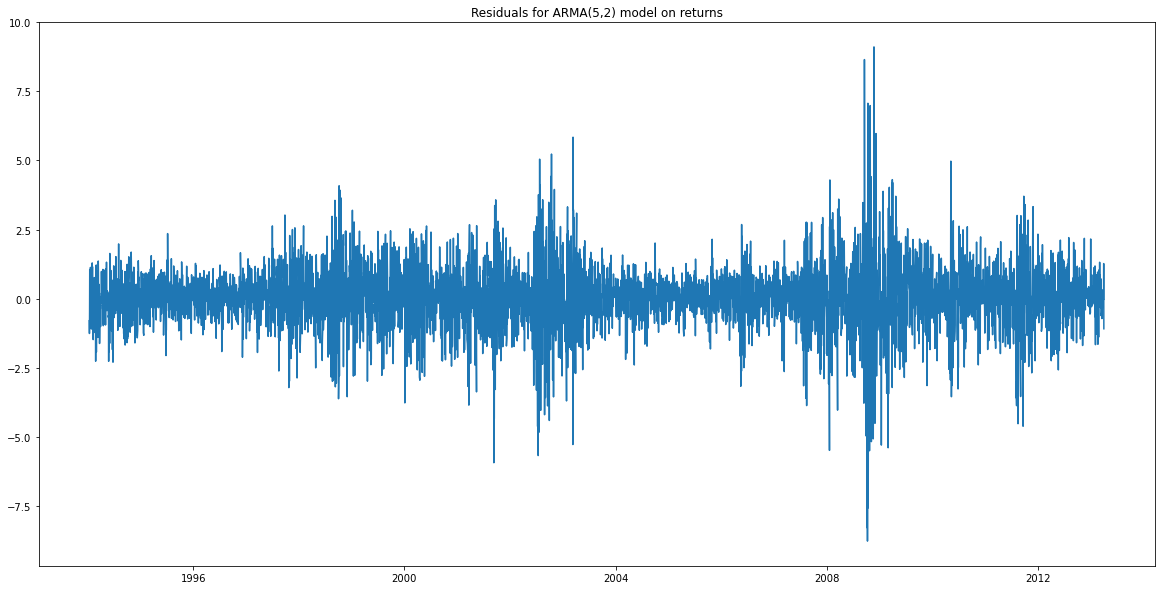

In [59]:
#ARMA(5,2) is the best model so far
#checking it's residuals
df_train['residuals_returns'] = results_ret_ar_5_ma_2.resid

#plotting the residuals
plt.plot(df_train['residuals_returns'])
plt.title('Residuals for ARMA(5,2) model on returns',size = 12)
plt.show()

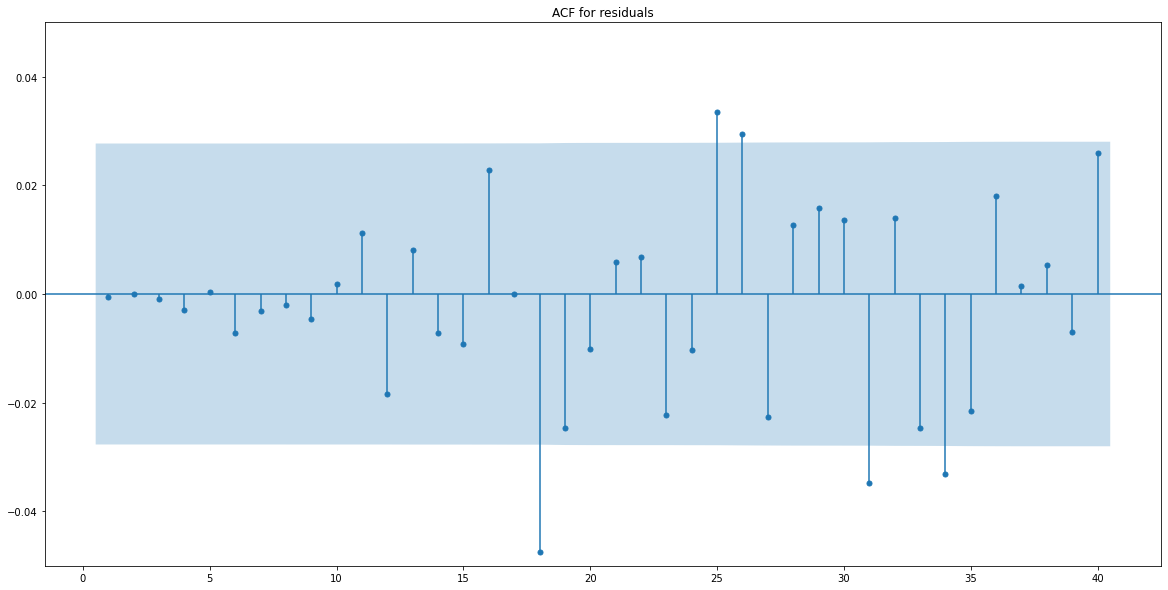

In [62]:
#plotting acf 
sgt.plot_acf(df_train.residuals_returns, lags = 40, zero = False)
plt.title("ACF for residuals", size = 12)
plt.ylim(-.05,.05)
plt.show()

## ARMA for prices

In [63]:
model_ar_1_ma_1 = ARIMA(df_train.market_value, order = (1,0,1))
results_ar_1_ma_1 = model_ar_1_ma_1.fit()
results_ar_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5013
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -27579.738
Date:                Sat, 28 Jan 2023   AIC                          55167.476
Time:                        16:54:18   BIC                          55193.556
Sample:                             0   HQIC                         55176.616
                               - 5013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.4483    369.277     13.782      0.000    4365.678    5813.218
ar.L1          0.9982      0.001   1197.957      0.000       0.997       1.000
ma.L1         -0.0192      0.010     -1.956      0.050      -0.038    3.62e-05
sigma2      3513.2696     41.129     85.421      0.000    3432.659    3593.880
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3275.05
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

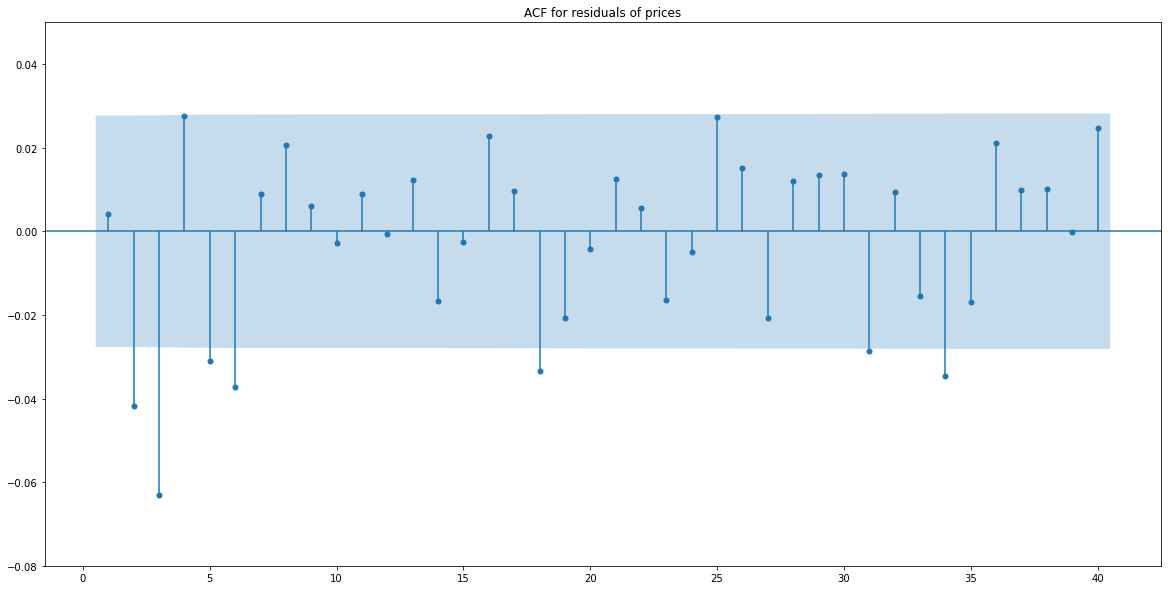

In [68]:
#to avoid selecting the best model only to find out we didn't incorporate enough lags, let's check the acf for residuals
df_train['residuals_prices'] = results_ar_1_ma_1.resid
#plotting acf 
sgt.plot_acf(df_train.residuals_prices, lags = 40, zero = False)
plt.title("ACF for residuals of prices", size = 12)
plt.ylim(-.08,.05)
plt.show()

In [69]:
#we see that 5 of the first 6 lags are significant, therefore we must look into variations of models inculding 6 lags in MA or AR
model_ar_6_ma_6 = ARIMA(df_train.market_value, order = (6,0,6))
results_ar_6_ma_6 = model_ar_6_ma_6.fit()
results_ar_6_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5013
Model:                 ARIMA(6, 0, 6)   Log Likelihood              -27549.964
Date:                Sat, 28 Jan 2023   AIC                          55127.929
Time:                        16:57:51   BIC                          55219.206
Sample:                             0   HQIC                         55159.916
                               - 5013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.4483    645.904      7.880      0.000    3823.500    6355.397
ar.L1         -0.1018      0.357     -0.285      0.775      -0.801       0.598
ar.L2         -0.2442      0.287     -0.852      0.394      -0.806       0.317
ar.L3         -0.0389      0.371     -0.105      0.917      -0.767       0.689
ar.L4          0.7769      0.331      2.350      0.019       0.129       1.425
ar.L5          0.3293      0.092      3.593      0.000       0.150       0.509
ar.L6          0.2736      0.173      1.585      0.113      -0.065       0.612
ma.L1          1.0812      0.356      3.036      0.002       0.383       1.779
ma.L2          1.2790      0.152      8.407      0.000       0.981       1.577
ma.L3          1.2442      0.444      2.802      0.005       0.374       2.114
ma.L4          0.4995      0.148      3.372      0.001       0.209       0.790
ma.L5          0.1646      0.166      0.994      0.320      -0.160       0.489
ma.L6         -0.0879      0.033     -2.653      0.008      -0.153      -0.023
sigma2      3483.9725     43.595     79.917      0.000    3398.529    3569.416
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2958.09
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.88   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [91]:
#nearly half the coefficients are insignificant suggesting there is a simpler model which is better than this
#checking all possible 10 models

#model_ar_5_ma_6 = ARIMA(df_train.market_value, order = (5,0,6))
#results_ar_5_ma_6 = model_ar_5_ma_6.fit()
#print(results_ar_5_ma_6.summary())
#print(LLR_test(model_ar_5_ma_6, model_ar_6_ma_6, DF = 1))
#ARMA(6,6) is not better than ARMA(5,6)

#model_ar_4_ma_6 = ARIMA(df_train.market_value, order = (4,0,6))
#results_ar_4_ma_6 = model_ar_4_ma_6.fit()
#print(results_ar_4_ma_6.summary())
#print(LLR_test(model_ar_4_ma_6, model_ar_5_ma_6, DF = 1))
#ARMA(4,6) is better than ARMA(5,6)

#model_ar_3_ma_6 = ARIMA(df_train.market_value, order = (3,0,6))
#results_ar_3_ma_6 = model_ar_3_ma_6.fit()
#print(results_ar_3_ma_6.summary())
#print(LLR_test(model_ar_3_ma_6, model_ar_4_ma_6, DF = 1))
#ARMA(3,6) is better than ARMA(4,6)

#model_ar_2_ma_6 = ARIMA(df_train.market_value, order = (2,0,6))
#results_ar_2_ma_6 = model_ar_2_ma_6.fit()
#print(results_ar_2_ma_6.summary())
#print(LLR_test(model_ar_2_ma_6, model_ar_3_ma_6, DF = 1))
#ARMA(2,6) is not better than ARMA(3,6)

#model_ar_1_ma_6 = ARIMA(df_train.market_value, order = (1,0,6))
#results_ar_1_ma_6 = model_ar_1_ma_6.fit()
#print(results_ar_1_ma_6.summary())
#print(LLR_test(model_ar_1_ma_6, model_ar_3_ma_6, DF = 2))
#ARMA(1,6) is not better than ARMA(3,6)

#one potential best model is ARMA(3,6)

#model_ar_6_ma_5 = ARIMA(df_train.market_value, order = (6,0,5))
#results_ar_6_ma_5 = model_ar_6_ma_5.fit()
#print(results_ar_6_ma_5.summary())
#print(LLR_test(model_ar_6_ma_5, model_ar_6_ma_6, DF = 1))
#ARMA(6,6) is not better than ARMA(6,5)

#model_ar_6_ma_4 = ARIMA(df_train.market_value, order = (6,0,4))
#results_ar_6_ma_4 = model_ar_6_ma_4.fit()
#print(results_ar_6_ma_4.summary())
#print(LLR_test(model_ar_6_ma_4, model_ar_6_ma_5, DF = 1))
#ARMA(6,5) is not better than ARMA(6,4)

#model_ar_6_ma_3 = ARIMA(df_train.market_value, order = (6,0,3))
#results_ar_6_ma_3 = model_ar_6_ma_3.fit()
#print(results_ar_6_ma_3.summary())
#print(LLR_test(model_ar_6_ma_3, model_ar_6_ma_4, DF = 1))
#ARMA(6,4) is better than ARMA(6,3)

#model_ar_6_ma_2 = ARIMA(df_train.market_value, order = (6,0,2))
#results_ar_6_ma_2 = model_ar_6_ma_2.fit()
#print(results_ar_6_ma_2.summary())
#print(LLR_test(model_ar_6_ma_2, model_ar_6_ma_4, DF = 2))
#ARMA(6,2) is better than ARMA(6,3)
#ARMA(6,2) is better than ARMA(6,4)

#model_ar_6_ma_1 = ARIMA(df_train.market_value, order = (6,0,1))
#results_ar_6_ma_1 = model_ar_6_ma_1.fit()
#print(results_ar_6_ma_1.summary())
#print(LLR_test(model_ar_6_ma_1, model_ar_6_ma_2, DF = 1))
#ARMA(6,1) is not better than ARMA(6,2)

#ARMA(6,2) is another potential best model

0.006


In [88]:
print('\nARMA(6,6): \tLLR = ', results_ar_6_ma_6.llf, '\tAIC = ',results_ar_6_ma_6.aic)
print('\nARMA(5,6): \tLLR = ', results_ar_5_ma_6.llf, '\tAIC = ',results_ar_5_ma_6.aic)
print('\nARMA(4,6): \tLLR = ', results_ar_4_ma_6.llf, '\tAIC = ',results_ar_4_ma_6.aic)
print('\nARMA(3,6): \tLLR = ', results_ar_3_ma_6.llf, '\tAIC = ',results_ar_3_ma_6.aic)
print('\nARMA(2,6): \tLLR = ', results_ar_2_ma_6.llf, '\tAIC = ',results_ar_2_ma_6.aic)
print('\nARMA(1,6): \tLLR = ', results_ar_1_ma_6.llf, '\tAIC = ',results_ar_1_ma_6.aic)

#ARMA(3,6) is the best among these


ARMA(6,6): 	LLR =  -27549.964282197216 	AIC =  55127.92856439443

ARMA(5,6): 	LLR =  -27547.976095036985 	AIC =  55121.95219007397

ARMA(4,6): 	LLR =  -27547.962706633138 	AIC =  55119.925413266275

ARMA(3,6): 	LLR =  -27548.019950447444 	AIC =  55118.03990089489

ARMA(2,6): 	LLR =  -27551.25538621746 	AIC =  55122.51077243492

ARMA(1,6): 	LLR =  -27551.456350725068 	AIC =  55120.912701450136


In [90]:
print('\nARMA(6,1): \tLLR = ', results_ar_6_ma_1.llf, '\tAIC = ',results_ar_6_ma_1.aic)
print('\nARMA(6,2): \tLLR = ', results_ar_6_ma_2.llf, '\tAIC = ',results_ar_6_ma_2.aic)
print('\nARMA(6,3): \tLLR = ', results_ar_6_ma_3.llf, '\tAIC = ',results_ar_6_ma_3.aic)
print('\nARMA(6,4): \tLLR = ', results_ar_6_ma_4.llf, '\tAIC = ',results_ar_6_ma_4.aic)
print('\nARMA(6,5): \tLLR = ', results_ar_6_ma_5.llf, '\tAIC = ',results_ar_6_ma_5.aic)
print('\nARMA(6,6): \tLLR = ', results_ar_6_ma_6.llf, '\tAIC = ',results_ar_6_ma_6.aic)

#ARMA(6,2) is best among these


ARMA(6,1): 	LLR =  -27552.490941120224 	AIC =  55122.98188224045

ARMA(6,2): 	LLR =  -27548.765785904125 	AIC =  55117.53157180825

ARMA(6,3): 	LLR =  -27553.590361572373 	AIC =  55129.180723144746

ARMA(6,4): 	LLR =  -27549.535210078255 	AIC =  55123.07042015651

ARMA(6,5): 	LLR =  -27547.85066124703 	AIC =  55121.70132249406

ARMA(6,6): 	LLR =  -27549.964282197216 	AIC =  55127.92856439443


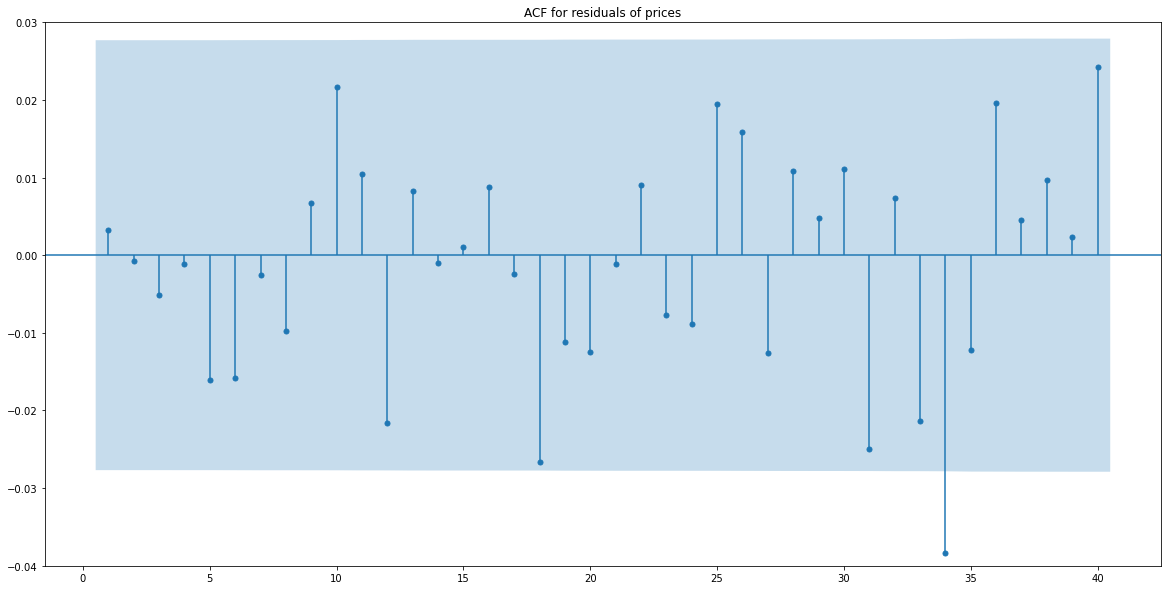

In [95]:
#checking residuals for both models
df_train['residuals_prices_ARMA(6,2)'] = results_ar_6_ma_2.resid
#plotting acf 
sgt.plot_acf(df_train['residuals_prices_ARMA(6,2)'], lags = 40, zero = False)
plt.title("ACF for residuals of prices", size = 12)
plt.ylim(-.04,.03)
plt.show()

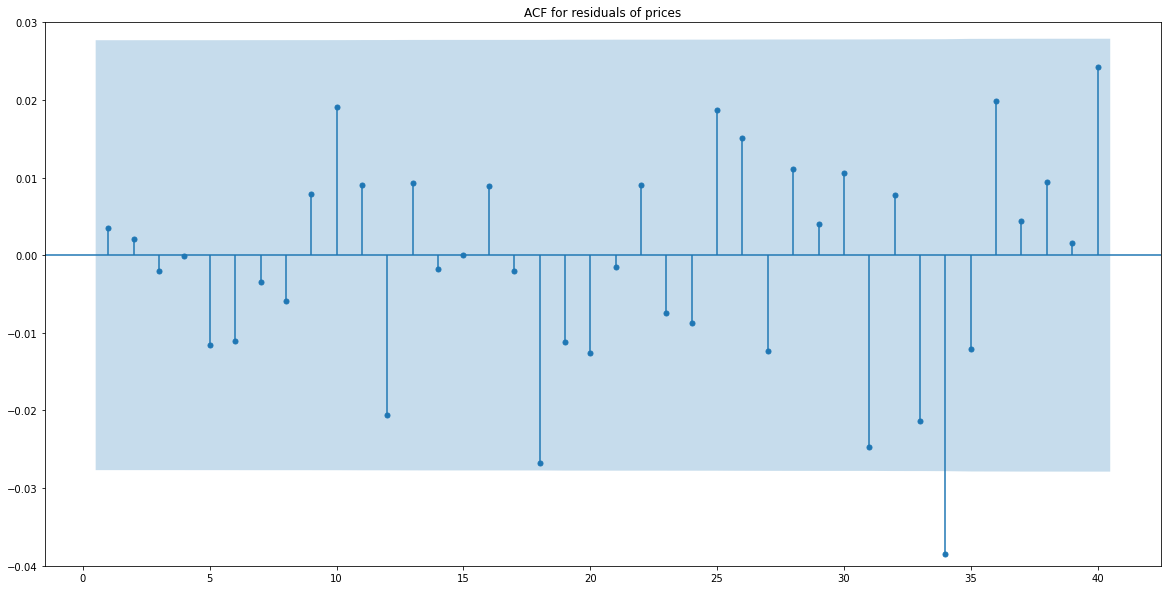

In [94]:
df_train['residuals_prices_ARMA(3,6)'] = results_ar_3_ma_6.resid
#plotting acf 
sgt.plot_acf(df_train['residuals_prices_ARMA(3,6)'], lags = 40, zero = False)
plt.title("ACF for residuals of prices", size = 12)
plt.ylim(-.04,.03)
plt.show()

In [ ]:
#both models look equally good